# Exercise 4

In [52]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import expon, erlang, bernoulli, norm, pareto
from enum import StrEnum
from heapq import heappush, heappop, heapify

## Events

arrived
serviced
blocked

In [53]:
class Event(StrEnum):
    ARRIVED = "Arrived"
    SERVICED = "Serviced"
    BLOCKED = "Blocked"

In [54]:
def simulate_system(inter_arrival_dist, service_time_dist, m=10, n_customers=10_000):

    service_units = [i for i in range(m)]

    arrival_times = np.cumsum(inter_arrival_dist.rvs(size=n_customers))

    events = [(time.item(), Event.ARRIVED) for time in arrival_times]
    heapify(events)

    n_serviced = 0
    n_blocked = 0
    events_processed = []

    while events:
        event = heappop(events)
        
        match event:
            case (time, Event.ARRIVED):
                if service_units:
                    new_event = (
                        time + service_time_dist.rvs(),
                        Event.SERVICED,
                        service_units.pop(),
                    )                
                else:
                    new_event = (
                        time,
                        Event.BLOCKED,
                    )
                heappush(events, new_event)
            case (_, Event.SERVICED, service_unit):
                service_units.append(service_unit)
                n_serviced += 1
            case (_, Event.BLOCKED):
                n_blocked += 1
        
        events_processed.append(event)

    return n_serviced, n_blocked, events_processed


def simulate_and_print_stats(inter_arrival_dist, service_time_dist, iterations=10, m=10, n_customers=10_000):
    blocked = np.empty(iterations)
    for i in range(iterations):
        _, n_blocked, events = simulate_system(inter_arrival_dist, service_time_dist, m, n_customers)
        blocked[i] = n_blocked

    blocked /= n_customers

    mean = np.mean(blocked)
    std = np.std(blocked)

    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2,3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[0, 2])
    xs = np.linspace(0, 20, 200)
    ax1.set_title("Inter-arrival distribution")
    ax1.plot(xs, inter_arrival_dist.pdf(xs))
    m = inter_arrival_dist.mean()
    ax1.axvline(m, color="g", linestyle="--", label=f"Mean: {m:.2f}")
    ax1.legend()

    ax2.set_title("Service time distribution")
    ax2.plot(xs, service_time_dist.pdf(xs))
    m = service_time_dist.mean()
    ax2.axvline(m, color="g", linestyle="--", label=f"Mean: {m:.2f}")
    ax2.legend()
    
    arrivals = [event[0] for event in events if event[1] == Event.ARRIVED]
    blocks = [event[0] for event in events if event[1] == Event.BLOCKED]

    ax3.set_title("Histogram of events (Last run)")
    ax3.hist(arrivals, bins=100, label="Arrivals")
    ax3.hist(blocks, bins=100, label="Blocked")
    ax3.legend()

    ax4.set_title(f"Block rate: {mean:.3f} +/- {1.96 * std:.5f}")
    ax4.bar(np.arange(iterations) + 1, blocked, alpha=0.8)
    ax4.hlines(mean, xmin=0, xmax=iterations + 1, label="Mean")
    ax4.hlines(mean + 1.96 * std, xmin=0, xmax=iterations + 1, linestyles="--", label="95% interval")
    ax4.hlines(mean - 1.96 * std, xmin=0, xmax=iterations + 1, linestyles="--")
    ax4.set_ylim(0, 1.25 * np.max(blocked))
    ax4.legend()

    fig.tight_layout()

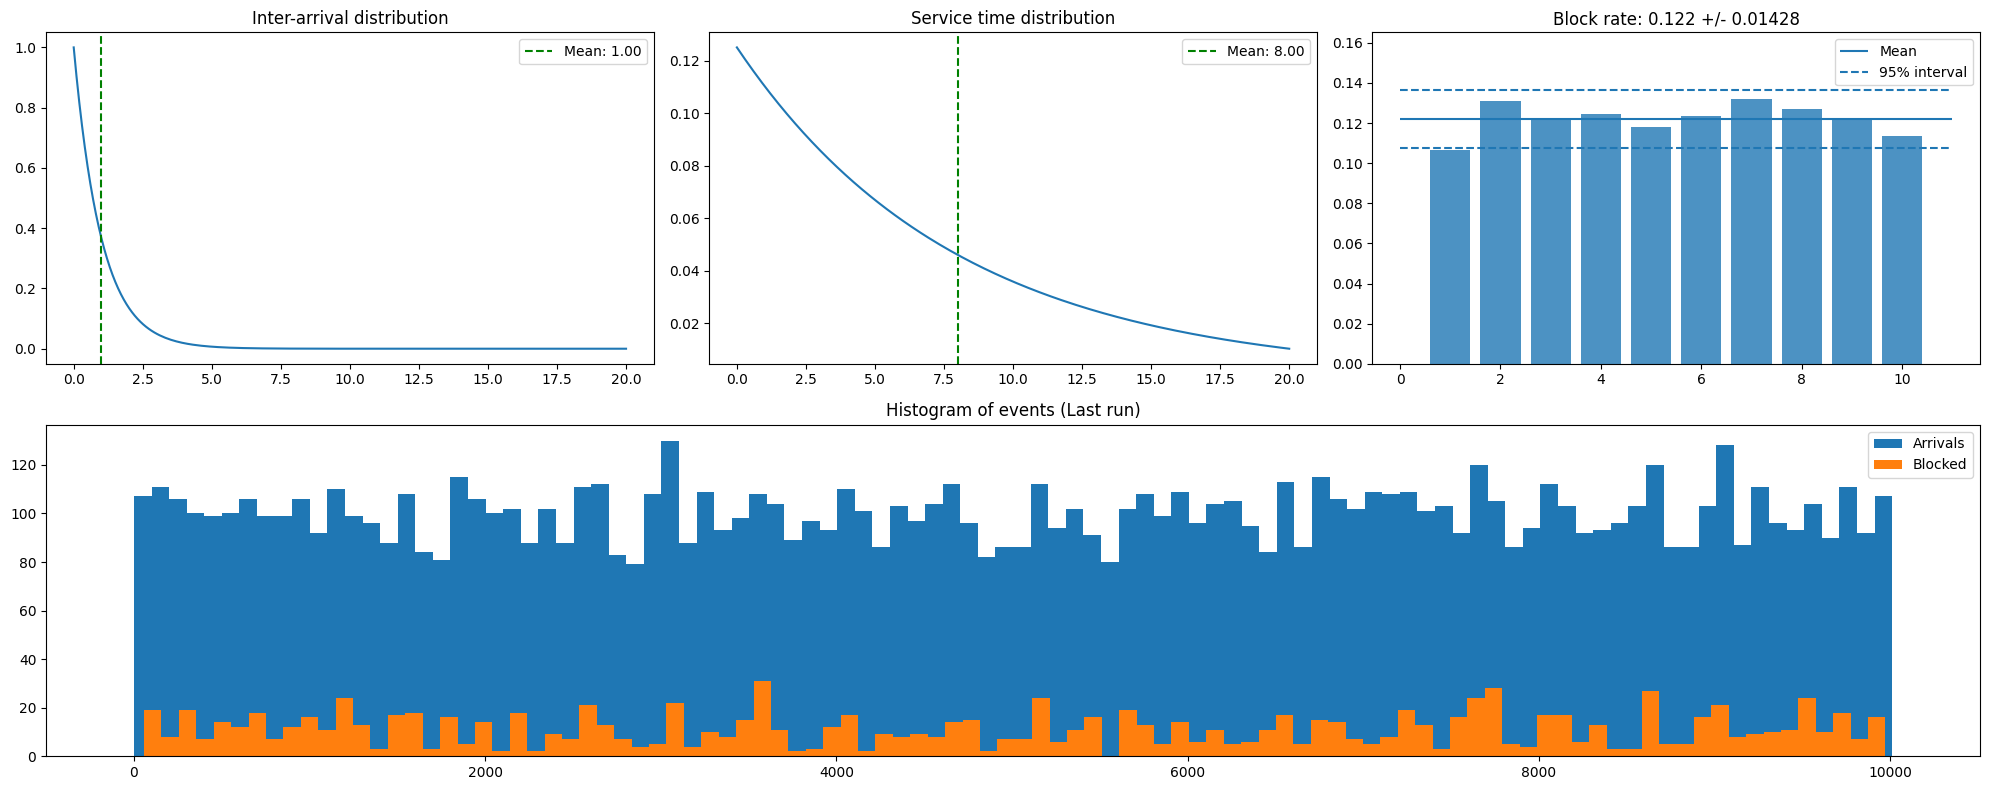

In [55]:
# 4.1

inter_arrival_dist = expon(scale=1)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

In [56]:
# verifying using analytical solution

A = 8
m = 10

def factorial(n):
    if n in (0, 1):
        return 1
    return n * factorial(n - 1)

a = A ** m / factorial(m)
b = sum(A ** i / factorial(i) for i in range(m + 1))

a / b

0.1216610642529515

In [57]:
# from wikipedia, supposedly more numerically stable
def erlang_b(E: float, m: int) -> float:
    """Calculate the probability of call losses."""
    inv_b = 1.0
    for j in range(1, m + 1):
        inv_b = 1.0 + inv_b * j / E
    return 1.0 / inv_b

erlang_b(A, m)

0.1216610642529515

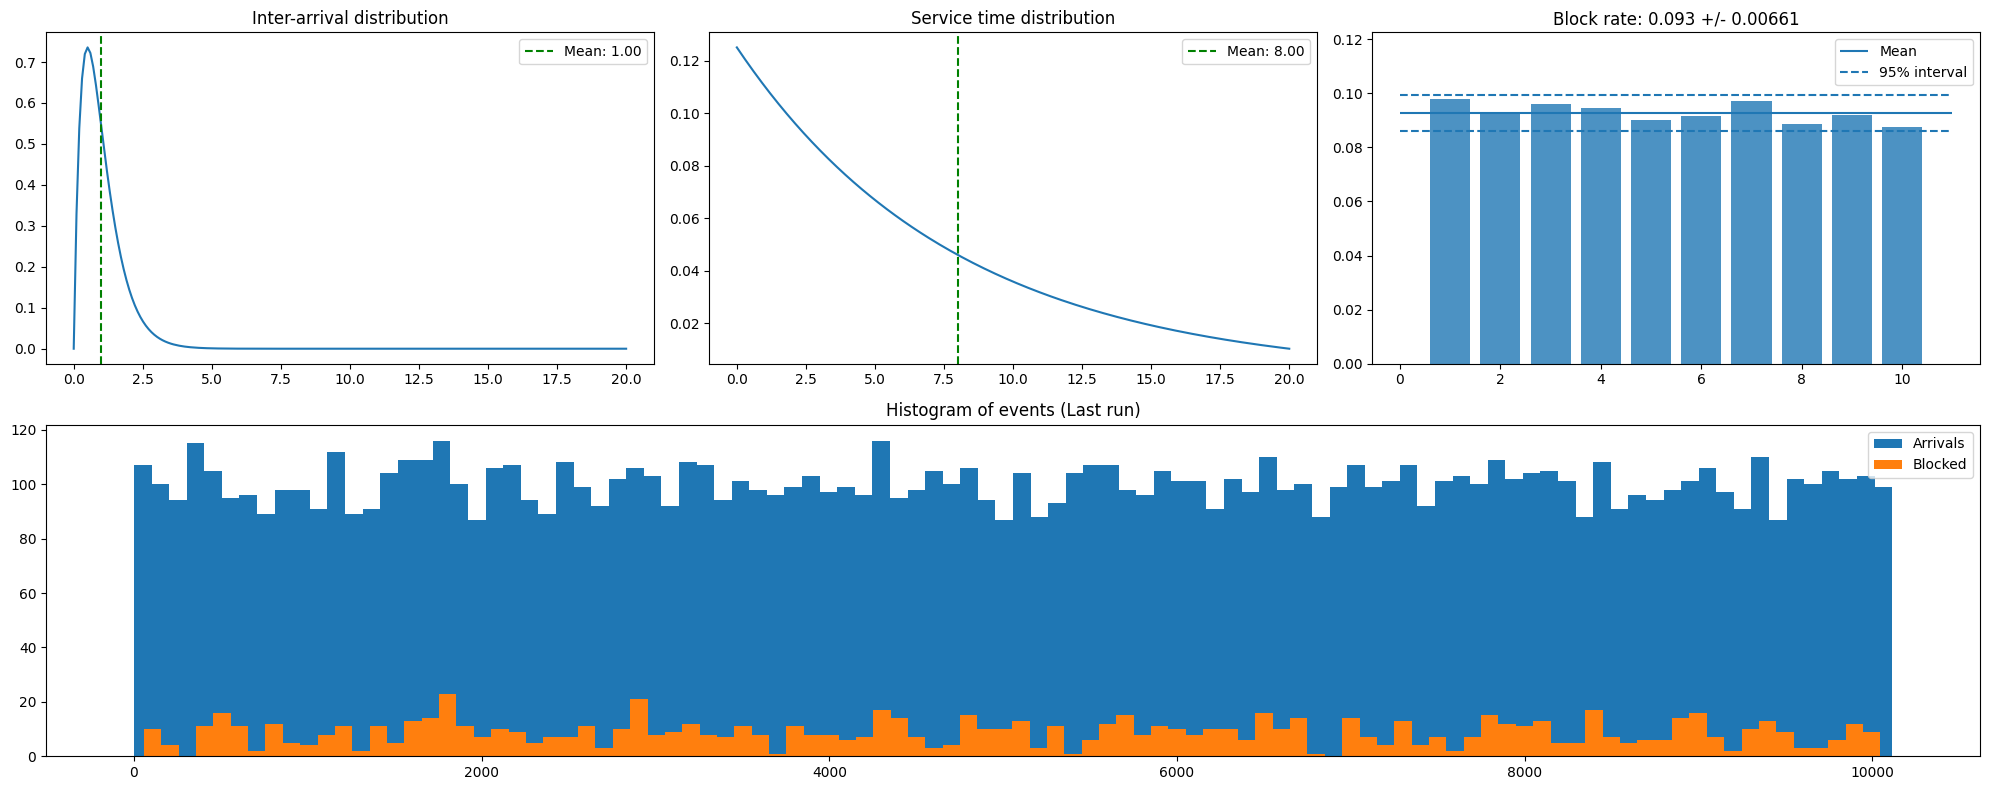

In [58]:
# 4.2.a
inter_arrival_dist = erlang(a=2, scale=1/2)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

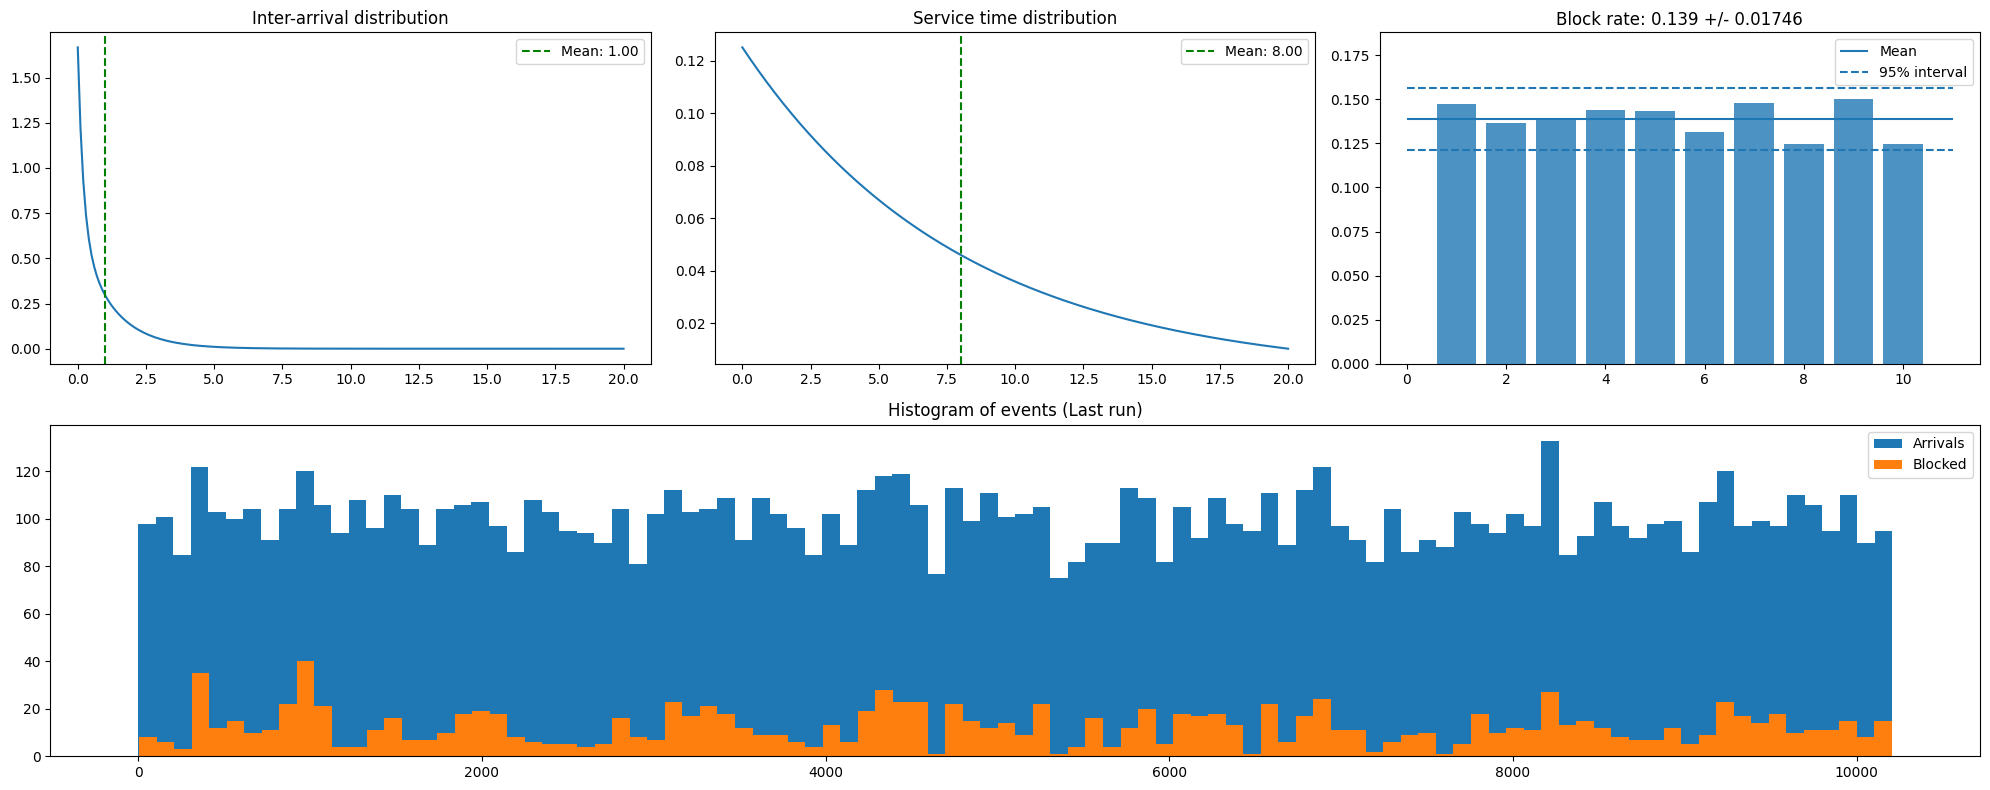

In [59]:
# 4.2.b
class hyperexpon:
    def __init__(self, p1, lambda1, lambda2):
        self.p1 = p1
        self.expon1 = expon(scale=1/lambda1)
        self.expon2 = expon(scale=1/lambda2)

    def mean(self):
        return self.p1 * self.expon1.mean() + (1 - self.p1) * self.expon2.mean()

    def rvs(self, size=1):
        mask = bernoulli.rvs(p=self.p1, size=size) == 1
        expon1 = self.expon1.rvs(size=size)
        expon2 = self.expon2.rvs(size=size)

        return np.where(mask, expon1, expon2)
    
    def pdf(self, xs):
        return self.p1 * self.expon1.pdf(xs) + (1 - self.p1) * self.expon2.pdf(xs)

inter_arrival_dist = hyperexpon(p1=0.8, lambda1=0.8333, lambda2=5.0)
service_time_dist = expon(scale=8)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

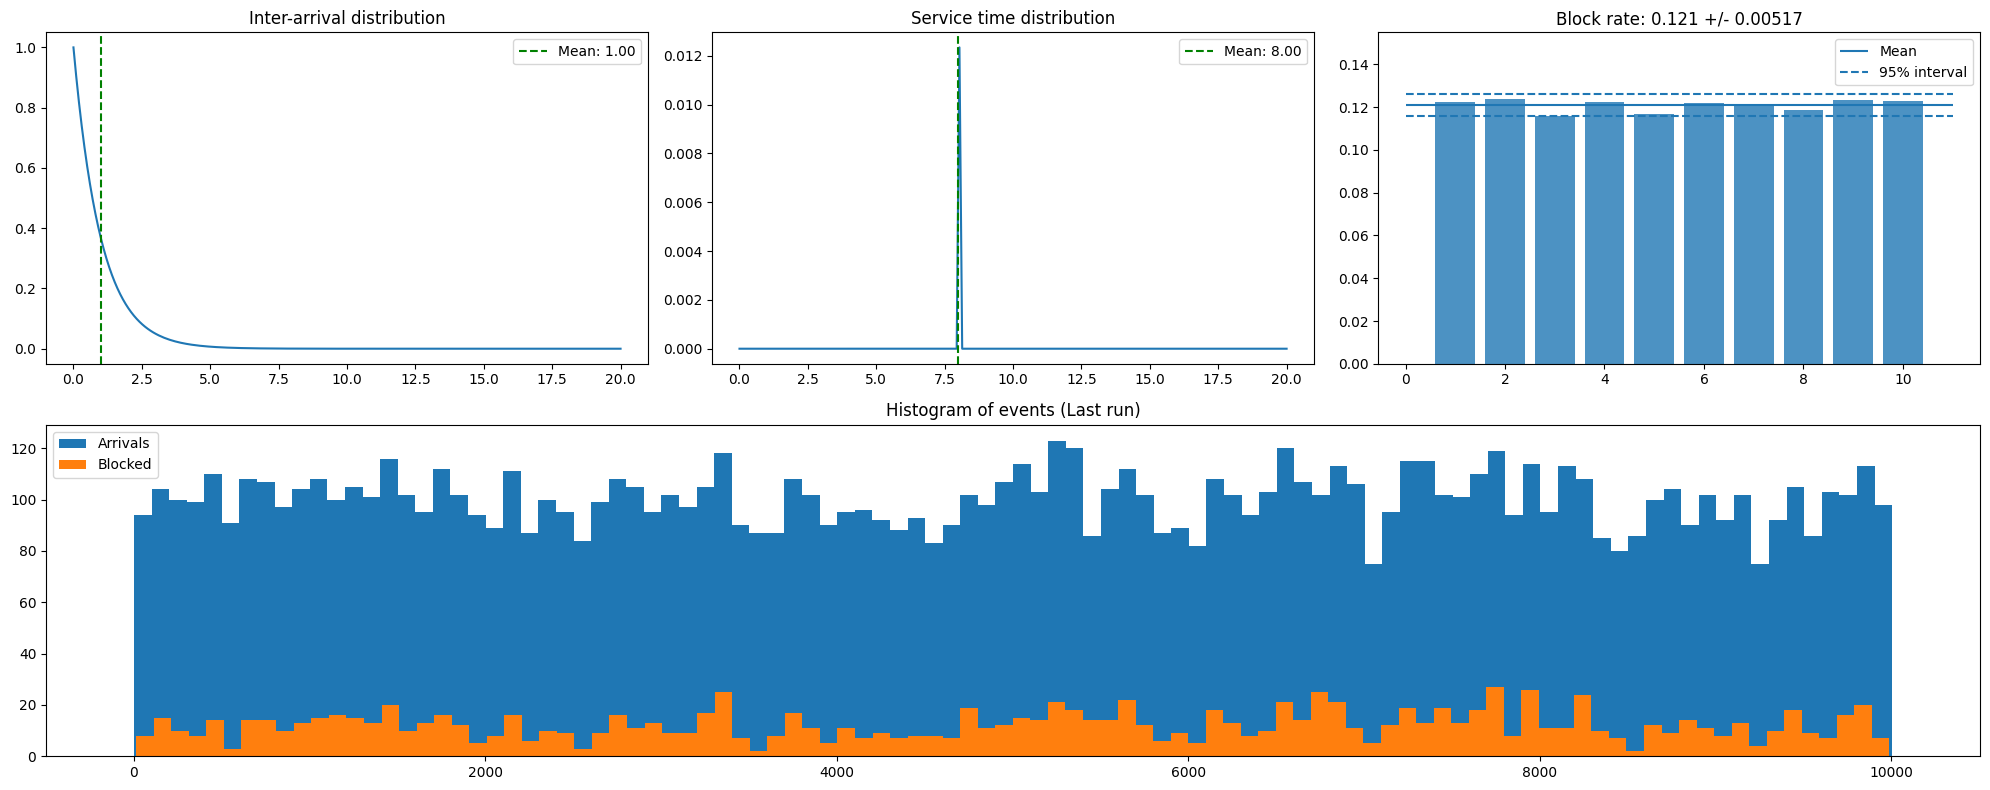

In [60]:
# 4.3.a
inter_arrival_dist = expon(scale=1)
service_time_dist = norm(loc=8, scale=0.01) # ~constant service time

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

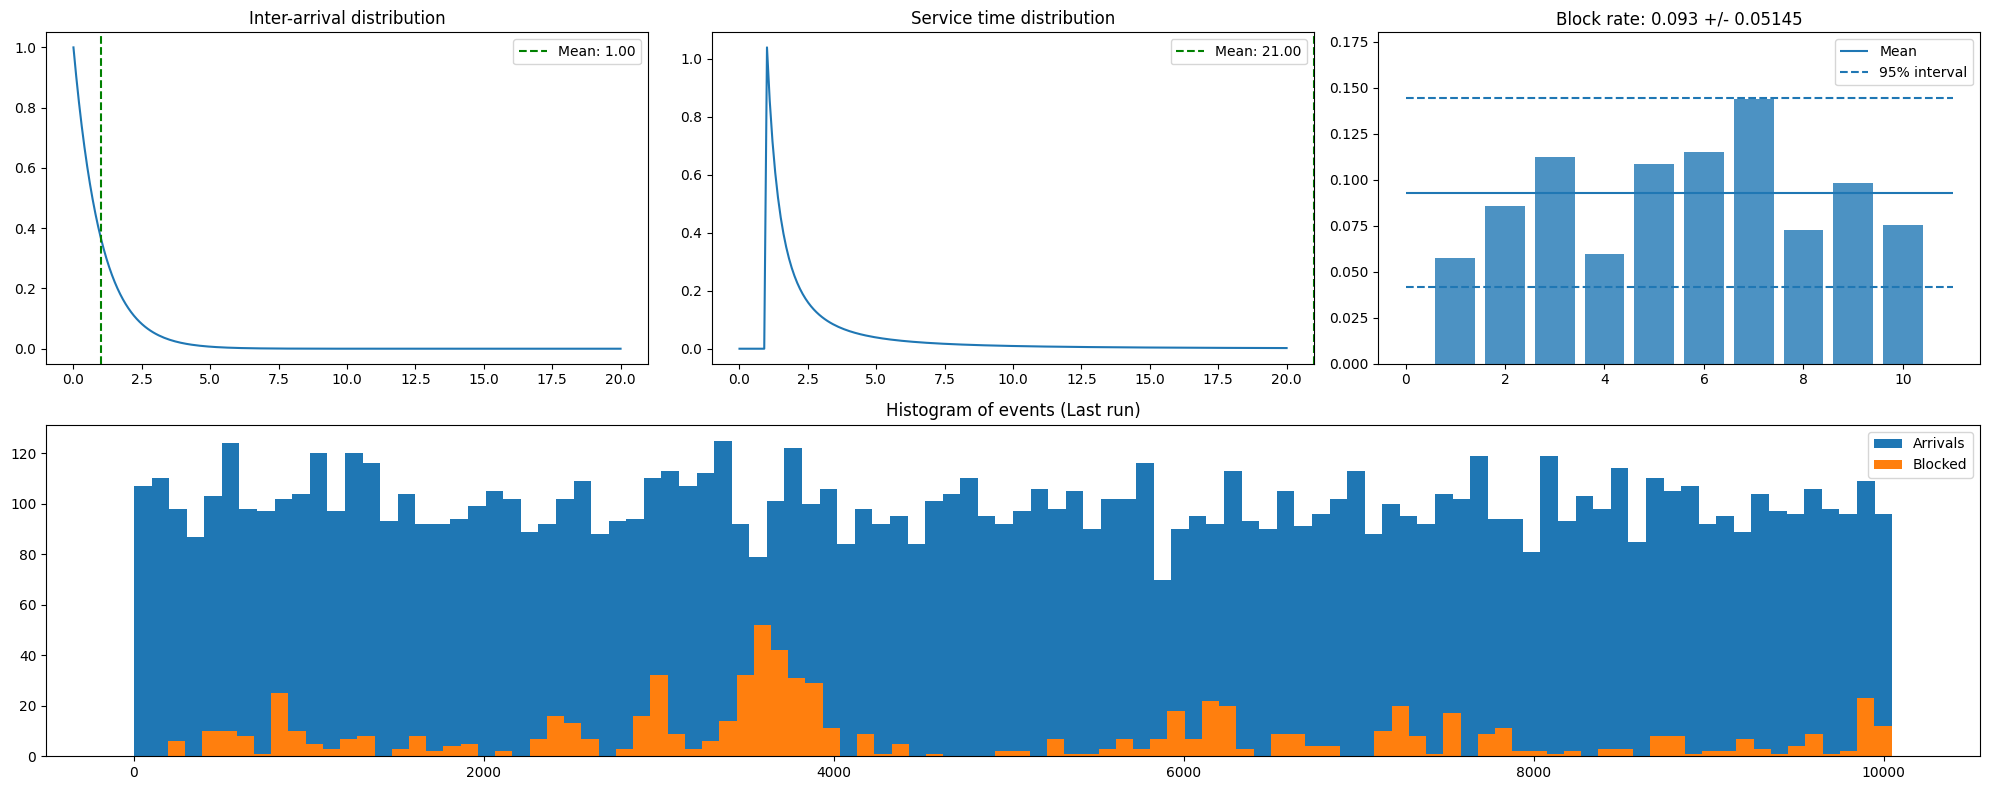

In [61]:
# 4.3.b
inter_arrival_dist = expon(scale=1)
service_time_dist = pareto(b=1.05)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)

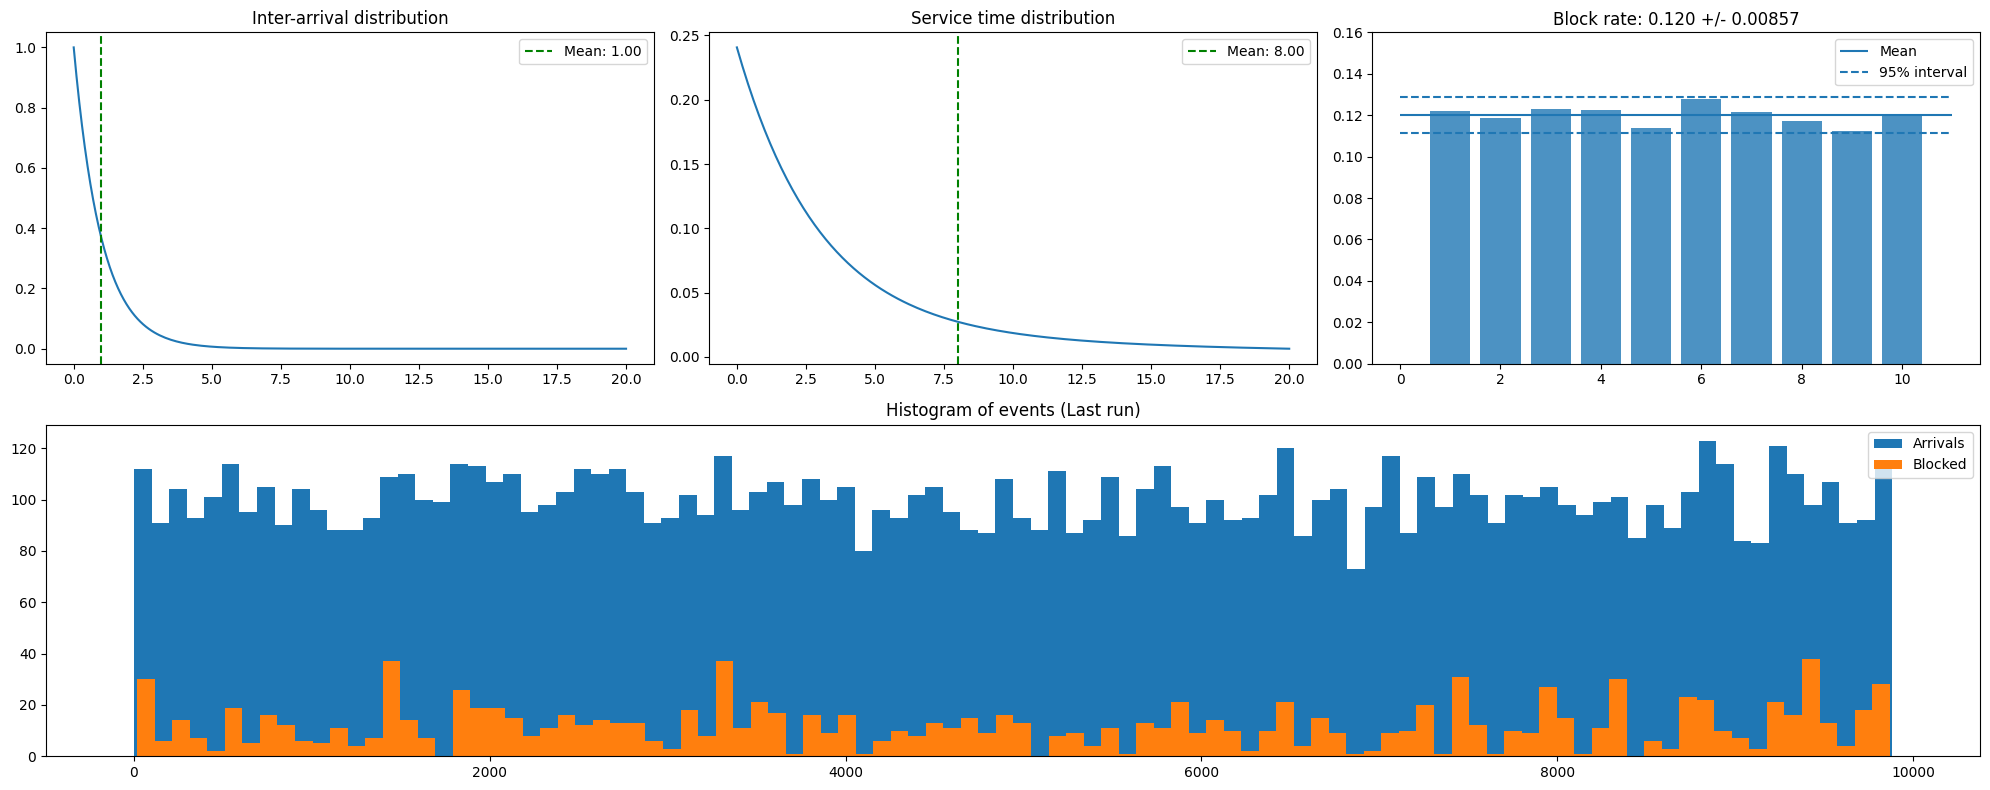

In [62]:
# 4.3.c
inter_arrival_dist = expon(scale=1)
service_time_dist = hyperexpon(1/3, 1/18, 1/3)

simulate_and_print_stats(inter_arrival_dist, service_time_dist)